In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import spacy
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora 
from pprint import pprint
from gensim.models import CoherenceModel, Word2Vec
import numpy as np
from sklearn.metrics.pairwise import cosine_distances
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine
import seaborn as sns
from wordcloud import WordCloud

In [3]:
df = pd.read_csv('spam_dataset.csv')
df.head(10)

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0
5,2949,ham,Subject: ehronline web address change\nthis me...,0
6,2793,ham,Subject: spring savings certificate - take 30 ...,0
7,4185,spam,Subject: looking for medication ? we ` re the ...,1
8,2641,ham,Subject: noms / actual flow for 2 / 26\nwe agr...,0
9,1870,ham,"Subject: nominations for oct . 21 - 23 , 2000\...",0


In [5]:
df.shape

(5171, 4)

Let's begin importing the dataset, it is a collection of emails classified as spam or non-spam, it consists of 5171 observations and 4 variables. During the course of the project we will focus in particular on the text variable, containing the body of the email, and the label and label_num variables, which indicate whether the email is marked as spam.

In [8]:
df.isnull().sum()

Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64

There are no null comments

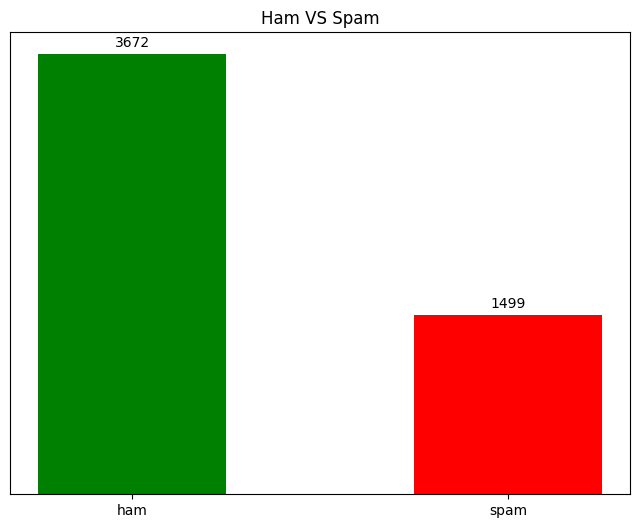

In [11]:
label_counts = df['label'].value_counts()
fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.5
bar_positions = range(len(label_counts))
bar_colors = ['green', 'red']
bars = ax.bar(bar_positions, label_counts.values, width=bar_width, color=bar_colors)
for bar, count in zip(bars, label_counts.values):
    height = bar.get_height()
    ax.annotate(str(count), xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), 
                textcoords='offset points', ha='center', va='bottom')

ax.set_xticks(bar_positions)
ax.set_xticklabels(label_counts.index)
ax.set_yticks([])
ax.set_title('Ham VS Spam')
plt.show()

Our dataset is unbalanced, theare are fewer spam osservation

# Training a classifier to identify SPAM

## Preprocessing

Our first task is to train a model that can recognize spam mails. First we proceed preprocessing our data. We are going to create a function that take the corpus of an email and“cleans” it through several steps:
1. Turn everything into lowercase.
2. Remove punctuation.
3. Tokenization and lemmatization using the en_core_web_sm model of the Spacy library.
4. Removing stopwords obtained via NLTK library, also added 'subject' as it was present in each email without adding meaning.

In [14]:
english_stopwords = stopwords.words('english') 
english_stopwords.extend(['subject'])
nlp = spacy.load('en_core_web_sm')
punctuation = set(string.punctuation)

In [16]:
def data_cleaner(sentence):
    """
    Prende in ingresso una frase, la processa e la restituisce "pulita"
    """
    sentence = sentence.lower()
    for c in string.punctuation:
        sentence = sentence.replace(c, " ")
    document = nlp(sentence)
    sentence = ' '.join(token.lemma_ for token in document)
    sentence = ' '.join(word for word in sentence.split() if word not in english_stopwords)
    sentence = re.sub('\d', '', sentence)
    
    return sentence

First we apply our function to the column 'text' and create a new column 'text_cleaned' containing the preprocessed text, then we display the result obtained

In [18]:
df['text_cleaned'] = df['text'].apply(data_cleaner)
df.head(10)

,Unnamed: 0,label,text,label_num,text_cleaned
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0,enron methanol meter follow note I give monda...
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0,hpl nom january see attached file hplnol xl...
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0,neon retreat ho ho ho around wonderful time ye...
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1,photoshop window office cheap main trending ab...
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0,indian spring deal book teco pvr revenue under...
5,2949,ham,Subject: ehronline web address change\nthis me...,0,ehronline web address change message intend eh...
6,2793,ham,Subject: spring savings certificate - take 30 ...,0,spring saving certificate take save use cust...
7,4185,spam,Subject: looking for medication ? we ` re the ...,1,look medication good source difficult make mat...
8,2641,ham,Subject: noms / actual flow for 2 / 26\nwe agr...,0,nom actual flow agree forward melissa jones ...
9,1870,ham,"Subject: nominations for oct . 21 - 23 , 2000\...",0,nomination oct see attached file hplnl xls...


In [19]:
print(df['text'][0])
print('--------------------------------------------------------------------------------')
print(df['text_cleaned'][0])

Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .
--------------------------------------------------------------------------------
enron methanol meter  follow note I give monday    preliminary flow datum provide daren please override pop daily volume presently zero reflect daily activity obtain gas control change need asap economic purpose


The cleanup was successful, we removed numbers, punctuation and stopwords. Now we continue with vectorization, we will start with an easy to implement approach, TF-IDF, with the parameter min_df=0.01 we indicate that only tokens appearing in at least 1% of the documents will be considered for the creation of the vocabulary and vector representation. To avoid data leakage we are going to perform a train test split on our dataset.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df['text_cleaned'], df['label_num'],
                                                    test_size=0.2, stratify=df['label_num'])

In [25]:
tfidv = TfidfVectorizer(min_df=0.01)
train_vectorized = tfidv.fit_transform(X_train)
test_vectorized = tfidv.transform(X_test)

## MultinomialNB model

Let's begin with a model that requires fewer computational resources, the multinomialNB, which is particularly suitable for text classification.

In [27]:
model = MultinomialNB()
model.fit(train_vectorized, y_train)

MultinomialNB()

In [29]:
y_pred = model.predict(test_vectorized)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       735
           1       0.86      0.93      0.90       300

    accuracy                           0.94      1035
   macro avg       0.92      0.94      0.93      1035
weighted avg       0.94      0.94      0.94      1035



We get good results although we might wish for something more for class 1(spam). Then we try to see if we can get better results with neural networks. Let's use a relatively simple network, MLPClassifier.

## MLPClassifier model

Let's create our network with a single hidden layer consisting of 100 neurons, we will use 'relu' as the activation function, and 'adam' as the optimization algorithm, our network will be trained for a maximum of 100 epochs and will stop if there is no improvement greater than 0.005. 

In [31]:
clf = MLPClassifier(activation='relu',
                    solver='adam',
                    max_iter=100,
                    hidden_layer_sizes=(100,),
                    tol=0.005)

In [33]:
clf.fit(train_vectorized, y_train)

MLPClassifier(max_iter=100, tol=0.005)

In [35]:
y_pred = clf.predict(test_vectorized)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       735
           1       0.96      0.94      0.95       300

    accuracy                           0.97      1035
   macro avg       0.97      0.96      0.96      1035
weighted avg       0.97      0.97      0.97      1035



We obtain better results than the previous model with precision and recall above 90% for both classes. Given the unbalanced nature of our dataset we check for malfunctions performing a stratified K-fold, we will rely on f1-score as the harmonic mean of precision and recall.

In [37]:
skf = StratifiedKFold(n_splits=5)
scores = cross_val_score(clf, test_vectorized, y_test, cv=skf, scoring='f1')
print('F1 scores:', scores)

F1 scores: [0.95726496 0.92307692 0.94117647 0.92307692 0.93548387]


We do not encounter abnormal behavior, our f1 is always close to 90%

# Identify Top Topics among SPAM emails in the dataset.

Let's start by grouping all SPAM emails together.

In [39]:
df_spam = df[df["label"] == "spam"]
df_spam.head()

,Unnamed: 0,label,text,label_num,text_cleaned
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1,photoshop window office cheap main trending ab...
7,4185,spam,Subject: looking for medication ? we ` re the ...,1,look medication good source difficult make mat...
10,4922,spam,Subject: vocable % rnd - word asceticism\nvcsc...,1,vocable rnd word asceticism vcsc brand new sto...
11,3799,spam,Subject: report 01405 !\nwffur attion brom est...,1,report wffur attion brom est inst siupie pgs...
13,3948,spam,Subject: vic . odin n ^ ow\nberne hotbox carna...,1,vic odin n ow berne hotbox carnal bride cutwor...


Then we preprocess the text using another approach; we will use the 'simple_preprocess' function of the gensim library that tokenizes the text, removes punctuation and accents, and converts the text to lower case. We will then go on to remove the stopwords.

In [41]:
def sent_to_words(items):
    for item in items:
        yield(gensim.utils.simple_preprocess(str(item), deacc=True))

def remove_stopwords(texts):
    return [[word for word in words if word not in english_stopwords] for words in texts]

I apply preprocessing to the 'text' column of my dataset

In [44]:
spam = df_spam['text']
data_words = list(sent_to_words(spam))
data_words = remove_stopwords(data_words)

Finally, we create a dictionary and a bag-of-words that will be useful in identifying various topics.

In [46]:
id2word = corpora.Dictionary(data_words)
corpus = [id2word.doc2bow(text) for text in data_words]

To find the various topics we are going to use LDAMulticore which needs an a priori knowledge of the number of topics we want to find. To know the optimal number of topics we will go to calculate the Coherence Score, which is a metric to calculate the quality of the topics obtained from LDA. We will then go on to create a function to calculate our Scores starting from a minimum of 2 topics to a maximum of 10. Finally we will display a graph that will help us understand the optimal number of topics to find.

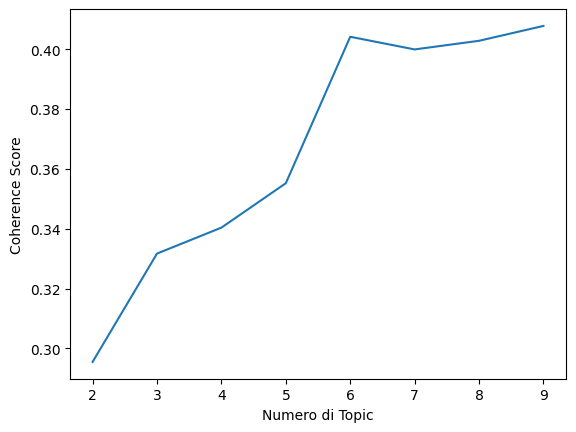

In [48]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Funzione per calcolare il Coherence Score per un dato numero di topic
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

start = 2
limit = 10
step = 1

model_list, coherence_values = compute_coherence_values(id2word, corpus, data_words, limit, start, step)

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Numero di Topic")
plt.ylabel("Coherence Score")
plt.show()

We get the highest score with the number 9, however in an effort to simplify the project we are going to extract 6 topics, given also the little difference between the two scores.

In [50]:
num_topics = 6

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       passes = 5)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.011*"font" + 0.011*"td" + 0.011*"http" + 0.011*"com" + 0.009*"nbsp" + '
  '0.008*"height" + 0.007*"www" + 0.007*"width" + 0.006*"size" + '
  '0.005*"computron"'),
 (1,
  '0.011*"company" + 0.009*"statements" + 0.006*"information" + 0.005*"may" + '
  '0.005*"within" + 0.005*"securities" + 0.005*"price" + 0.005*"stock" + '
  '0.005*"report" + 0.004*"investment"'),
 (2,
  '0.005*"http" + 0.004*"www" + 0.004*"com" + 0.003*"us" + 0.002*"get" + '
  '0.002*"new" + 0.002*"viagra" + 0.002*"save" + 0.002*"best" + '
  '0.002*"please"'),
 (3,
  '0.002*"http" + 0.002*"money" + 0.002*"com" + 0.002*"calls" + 0.001*"back" + '
  '0.001*"time" + 0.001*"www" + 0.001*"get" + 0.001*"dosage" + 0.001*"stock"'),
 (4,
  '0.007*"pills" + 0.004*"get" + 0.004*"com" + 0.003*"us" + 0.003*"http" + '
  '0.003*"one" + 0.003*"please" + 0.003*"money" + 0.003*"business" + '
  '0.003*"new"'),
 (5,
  '0.005*"com" + 0.004*"http" + 0.003*"please" + 0.003*"get" + 0.003*"account" '
  '+ 0.002*"email" + 0.002*"said" +

# Calculate the semantic distance between the obtained topics to infer their heterogeneity.

Once we get the topics we go to calculate their semantic distance to see how heterogeneous they are, to do this we will use the 'glove-wiki-gigaword-300' model

In [58]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')

Then we extract the words from all the topics and add them to a list, each topic will have its own list.

In [62]:
topic_words = []

for topic in lda_model.print_topics():
    words = [word.split('*')[1].replace('"', '').strip() for word in topic[1].split('+')]
    topic_words.append(words)

Now create a function that calculates the average embedding vector for each list created and iterate over all our lists.

In [64]:
def avg_vector(sentence):
    to_remove = 0
    vector = np.zeros(300)
    for word in sentence:
        if word in glove_vectors.key_to_index.keys():
            vector += glove_vectors.get_vector(word)
        else:
            to_remove += 1
    if len(sentence)== to_remove:
        return np.zeros(300)
        
    return vector/(len(sentence)-to_remove)

In [66]:
vectors = []

for topic in topic_words:
    vectors.append(avg_vector(topic))

We now create a similarity matrix calculating the cosine similarity values for each pair of vectors.

In [68]:
num_topics = len(vectors)
similarity_matrix = np.zeros((num_topics, num_topics))

for i in range(num_topics):
    for j in range(num_topics):
        similarity_matrix[i, j] = 1 - cosine(vectors[i], vectors[j])

Let's visualize our matrix, the higher the value, the more similar the topics will be.

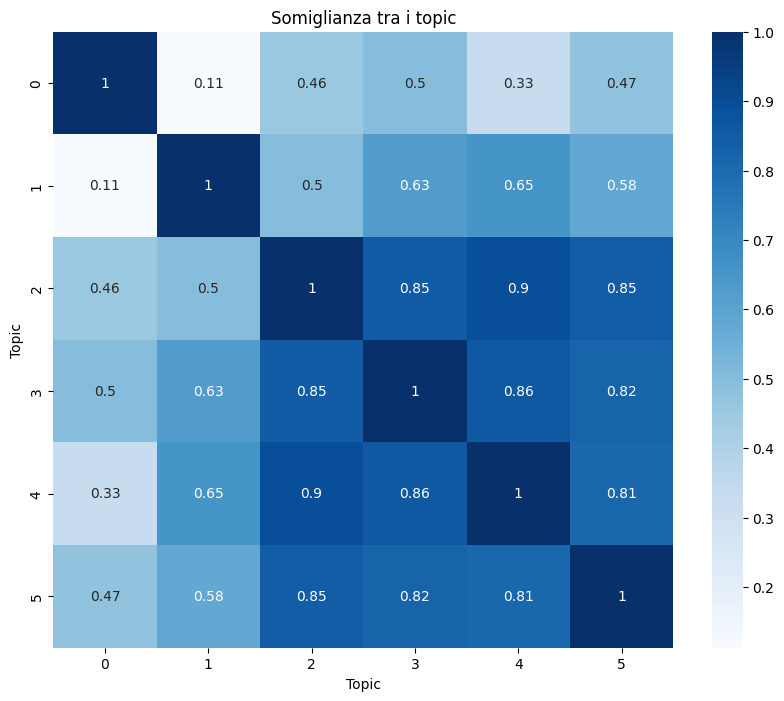

In [70]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='Blues', ax=ax)

ax.set_title('Somiglianza tra i topic')
ax.set_xlabel('Topic')
ax.set_ylabel('Topic')

plt.show()

# Extracting Organizations from NON SPAM emails.

In the end we extract from the non-spam mails the names of organizations, to do this we will use NER(Named Entity Recognition) which will allow us to extract the names of organizations. We start by taking only the 'ham' mails.

In [73]:
df_ham = df[df["label"] == "ham"]
df_ham.head()

,Unnamed: 0,label,text,label_num,text_cleaned
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0,enron methanol meter follow note I give monda...
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0,hpl nom january see attached file hplnol xl...
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0,neon retreat ho ho ho around wonderful time ye...
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0,indian spring deal book teco pvr revenue under...
5,2949,ham,Subject: ehronline web address change\nthis me...,0,ehronline web address change message intend eh...


Let's create a function that allows us, via the 'en_core_web_sm' model of the Spacy library, to extract from our emails corpus only the names that the model recognizes as ORGs; the function returns a list containing the names.

In [76]:
def extract_organizations(text):
    doc = nlp(text)
    organizations = []
    for ent in doc.ents:
        if ent.label_ == 'ORG':
            organizations.append(ent.text)
    return organizations

Apply it to our dataframe's column 'text_cleaned'

In [78]:
df_ham['organizations'] = df_ham['text_cleaned'].apply(extract_organizations)
df_ham.head(10)

/var/folders/8g/2lyvxf_x4d740s9m_1ljfhsr0000gn/T/ipykernel_73070/3772494285.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ham['organizations'] = df_ham['text_cleaned'].apply(extract_organizations)


,Unnamed: 0,label,text,label_num,text_cleaned,organizations
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0,enron methanol meter follow note I give monda...,[enron methanol meter]
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0,hpl nom january see attached file hplnol xl...,[]
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0,neon retreat ho ho ho around wonderful time ye...,[shop antique]
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0,indian spring deal book teco pvr revenue under...,[]
5,2949,ham,Subject: ehronline web address change\nthis me...,0,ehronline web address change message intend eh...,[]
6,2793,ham,Subject: spring savings certificate - take 30 ...,0,spring saving certificate take save use cust...,[locker kids foot locker store u foot locker c...
8,2641,ham,Subject: noms / actual flow for 2 / 26\nwe agr...,0,nom actual flow agree forward melissa jones ...,[]
9,1870,ham,"Subject: nominations for oct . 21 - 23 , 2000\...",0,nomination oct see attached file hplnl xls...,[]
12,1488,ham,"Subject: enron / hpl actuals for august 28 , 2...",0,enron hpl actual august teco tap enron h...,[enron hpl actual]
14,3418,ham,Subject: tenaska iv july\ndarren :\nplease rem...,0,tenaska iv july darren please remove price ten...,"[tenaska, tenaska]"


The column 'organizations' containing all names recognized as ORGs found within the corpora has been created; however, we note that some lists are empty, so we proceed to delete these observations.

In [80]:
df_ham = df_ham[df_ham['organizations'].apply(len) != 0]
df_ham.head(10)

,Unnamed: 0,label,text,label_num,text_cleaned,organizations
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0,enron methanol meter follow note I give monda...,[enron methanol meter]
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0,neon retreat ho ho ho around wonderful time ye...,[shop antique]
6,2793,ham,Subject: spring savings certificate - take 30 ...,0,spring saving certificate take save use cust...,[locker kids foot locker store u foot locker c...
12,1488,ham,"Subject: enron / hpl actuals for august 28 , 2...",0,enron hpl actual august teco tap enron h...,[enron hpl actual]
14,3418,ham,Subject: tenaska iv july\ndarren :\nplease rem...,0,tenaska iv july darren please remove price ten...,"[tenaska, tenaska]"
16,2643,ham,Subject: re : first delivery - wheeler operati...,0,first delivery wheeler operate vance deal cre...,"[acton corp enron, enron enron christy]"
17,3137,ham,"Subject: swift - may 2001 vols\nsean ,\nfyi , ...",0,swift may vol sean fyi check purchase swift t...,"[enron, mike morris corp enron enron]"
20,3261,ham,Subject: fw : ercot load comparison\n- - - - -...,0,fw ercot load comparison original message gilb...,"[fw ercot load, smith doug send, smith corp en..."
23,2221,ham,Subject: re : tenaska iv 10 / 00\nwe have rece...,0,tenaska iv receive money spot sale tenaska i...,"[tenaska, tenaska, tenaska]"
25,1811,ham,Subject: re : enron / hpl actuals for october ...,0,enron hpl actual october revision please not...,[enron hpl actual]


In the end we go on to create a word cloud to display the words that most frequently occur within the processed emails.

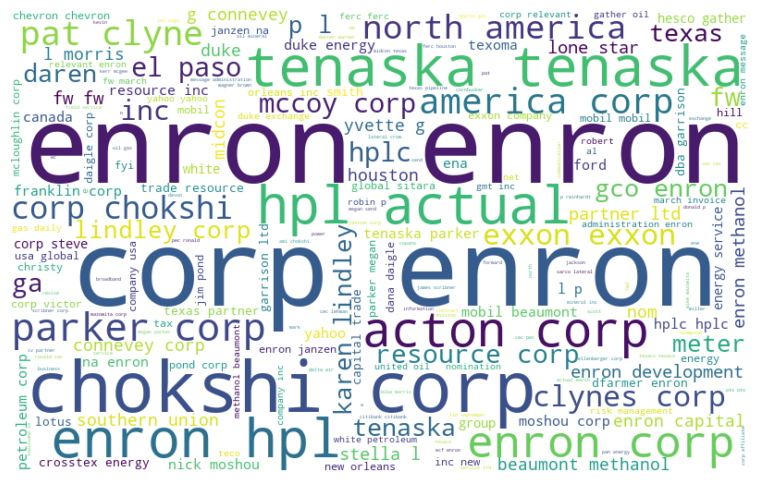

In [100]:
organizations_text = ' '.join([' '.join(org) for org in df_ham['organizations']])

wordcloud = WordCloud(width=800, height=500, background_color='white').generate(organizations_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()